# 以 Q-learning 求解 Cliff Walking

## 載入套件

In [1]:
import matplotlib
import numpy as np
import random
import sys
import gymnasium as gym

## 載入遊戲

In [2]:
env = gym.make('CliffWalking-v0')

## 定義 ε-greedy策略

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        # 每個行動的機率初始化，均為 ε / n
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        # 最佳行動的機率再加 1 - ε 
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

## 定義 Q-learning 策略

In [11]:
from collections import defaultdict
from lib import plotting
import itertools

def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # 行動值函數初始化
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # 記錄 所有回合的長度及獎勵
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # 使用 ε-greedy策略
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # 實驗 N 回合
    for i_episode in range(num_episodes):
        # 每 100 回合顯示除錯訊息
        if (i_episode + 1) % 100 == 0:
            print(f"\r {(i_episode + 1)}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除畫面
        
        # 開始依策略實驗
        state, _ = env.reset()
        # 每次走一步就更新狀態值
        for t in itertools.count():            
            # 使用 ε-greedy策略
            action_probs = policy(state)
            # 選擇下一步行動
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # 更新長度及獎勵
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # 選擇最佳行動
            best_next_action = np.argmax(Q[next_state])    
            # 更新狀態值
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

## 執行 Q-learning 策略

In [12]:
Q, stats = q_learning(env, 1000, discount_factor=0.9, alpha=0.5, epsilon=0.1)

 1000/1000回合.

## 顯示執行結果

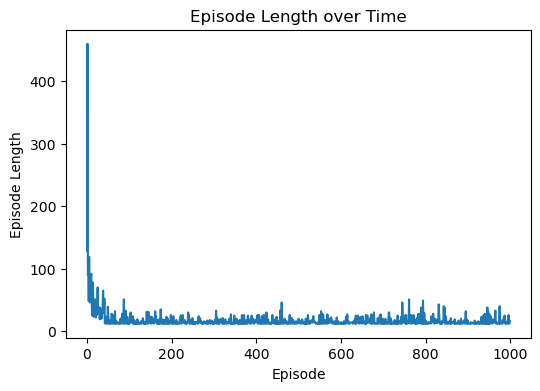

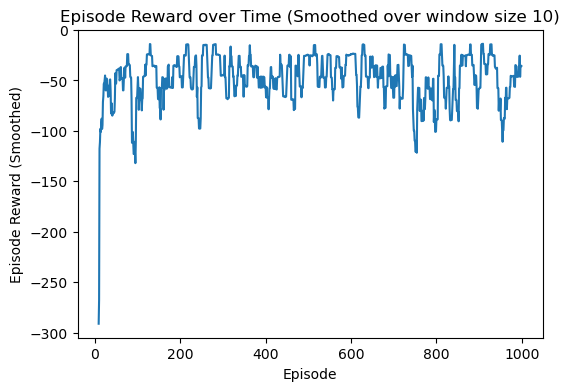

In [13]:
# 顯示結果
fig = plotting.plot_episode_stats(stats)

In [14]:
Q

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {36: array([  -7.45813417, -106.71232075,   -7.71232075,   -7.71232074]),
             24: array([-7.71122512, -7.17570464, -7.71232075, -7.45813417]),
             12: array([-7.66684032, -7.45737617, -7.45769222, -7.49193135]),
             0: array([-7.58514763, -7.50613889, -7.46650485, -7.49927199]),
             1: array([-7.30033977, -7.29262392, -7.33474799, -7.40497787]),
             2: array([-7.16147211, -7.05065644, -7.09941216, -7.26129657]),
             3: array([-6.76466455, -6.7552417 , -6.77761223, -7.03645503]),
             4: array([-6.57660997, -6.43633033, -6.43128142, -6.73851361]),
             5: array([-6.22646397, -6.07812858, -6.08003129, -6.33160704]),
             6: array([-5.81879665, -5.66037998, -5.67289593, -6.00902125]),
             7: array([-5.23490668, -5.19025624, -5.19436069, -5.2639626 ]),
             8: array([-4.68044768, -4.66785358, -4.6718038 , -4.78099985]),
 

## 將行動策略轉換為最佳行動

In [15]:
dict1 = {0:'U', 1:'R', 2:'D', 3:'L'}
for row in range(4):
    for column in range(12):
        print(dict1[np.argmax(Q[row * 12 + column])], ' ', end='')
    print()

D  R  R  R  D  R  R  R  R  R  D  D  
R  R  D  R  R  R  R  R  R  R  R  D  
R  R  R  R  R  R  R  R  R  R  R  D  
U  U  U  U  U  U  U  U  U  U  U  U  


## 測試行動策略

In [16]:
def play_episodes(environment, n_episodes, policy):
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
            done = False
            state, info = environment.reset()
            while not done:
                    # Select best action to perform in a current state
                    action = np.argmax(policy[state])
                    # Perform an action an observe how environment acted in response
                    next_state, reward, terminated, truncated, info = environment.step(action)
                    done = terminated or truncated
                    # Summarize total reward
                    total_reward += reward
                    # Update current state
                    state = next_state
                    # Calculate number of wins over episodes
                    if done and reward > -100:
                            wins += 1
    average_reward = total_reward / n_episodes
    return wins, total_reward, average_reward

# 測試 1000 回合
n_episodes = 1000
wins, total_reward, average_reward = play_episodes(env, n_episodes, Q)
print(f'number of wins over {n_episodes} episodes = {wins}')
print(f'average reward over {n_episodes} episodes = {average_reward} \n\n')

number of wins over 1000 episodes = 1000
average reward over 1000 episodes = -13.0 


